In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

#transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc 
from sklearn.metrics import precision_recall_curve

#Predictive Power Score
import ppscore as pps



import re
import Levenshtein

In [401]:
#for model explainability
import eli5

In [402]:
import imblearn
print(imblearn.__version__)

0.7.0


### Reading in the data

In [403]:
df = pd.read_csv('data.csv',encoding='latin-1')

### Cleaning operations

In [404]:
#strip whitespace from column names
df = df.rename(columns=lambda x: x.strip())

#strip whitespace from values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#replace '-' in annual salary with 0
df['annual_salary'] = df['annual_salary'].replace('-',0)

#convert annual salary to int type
df['annual_salary'] = df['annual_salary'].astype('int64')

#replace NaNs in the IP country column, as missing values here may also be as valuable
df['ip_country'] = df['ip_country'].fillna('N/A')

In [405]:
#quick check of fraud rate of purchase amount
df.groupby('is_fraud')['purchase_amount'].sum()[1] / df.groupby('is_fraud')['purchase_amount'].sum()[0] * 100

11.50165772696562

### Feature Engineering

In [406]:
#Get the purchase amount as a percentage of the reported salary
df['purchase_div_salary'] = (df.query('purchase_amount > 0')['purchase_amount'] / df.query('annual_salary >0')['annual_salary']*100)

#Get the purchase hour from time_of_purchase 
df[['purchase_hour','minute','second']] = df['time_of_purchase'].str.split(':',expand=True)
df.drop(columns=['minute','second'],inplace=True)

#get full name from fname and lname
df['full_name'] = df.fname + ' ' + df.lname

In [407]:
#A method for calculating the similarity of emails to customer names
#This function strips out punctuation and numbers from emails, then calculates the Levenshtein distance between the name and email
#Levenshtein distance is the number of single character changes to get from one string to another
#this function returns the levenshtein distance as a proportion of the length of the first input (email in this case)

def compare_email_name(email, name):
    name = name
    email = email

    lower_name = str.lower(name)
    lower_email = str.lower(str.split(email,'@')[0])
    nopunc_email = re.sub('[!@#$%^&*()-=+.,]', ' ', lower_email)
    nonum_email = re.sub(r'[0-9]+', '', nopunc_email).strip()

    distance = round(Levenshtein.distance(lower_name,nonum_email) / len(email),1)
    #print(f'The name {lower_name} is {distance} characters different to the email {email}')
    return distance


In [408]:
#vectorizing the compare_email_name function
v = np.vectorize(compare_email_name)

In [409]:
df['lev_distance'] = v(df.email, df.full_name)


In [410]:
#fillna with mean for the num_vars df for the purpose of the VIF calculation
df['purchase_div_salary'] = df['purchase_div_salary'].fillna(df['purchase_div_salary'].mean())

In [411]:
#creating a Domain column from the email address column

df['domain'] = df['email'].str.split('@').str[1]
df['domain'] = df['domain'].str.replace('.','')

<ipython-input-411-e10f31f8ab35>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['domain'] = df['domain'].str.replace('.','')


In [412]:
#converting has_paid_before from f and t to 0 and 1
df['has_paid_before'].replace('f',0, inplace=True)
df['has_paid_before'].replace('t',1, inplace=True)

#converting is_fraud from f and t to 0 and 1
df['is_fraud'].replace('f',0, inplace=True)
df['is_fraud'].replace('t',1, inplace=True)


In [413]:
df.head()

,transaction_id,time_of_purchase,purchase_amount,customer_id,fname,lname,age,addr_city,email,has_paid_before,annual_salary,type_of_goods,delivery_city,ip_country,is_fraud,purchase_div_salary,purchase_hour,full_name,lev_distance,domain
0,2001563,16:52:11,15249,3941,Agneta,Jansson,28,Stockholm,agneta.jansson@hotmail.com,1,0,Clothing,Stockholm,SE,0,14.079045,16,Agneta Jansson,0.0,hotmailcom
1,1997663,14:20:45,9334,122158,Agneta,Gustafsson,73,Malmo,agneta_gustafsson@gmail.com,0,340000,Dating,Malmo,SE,0,2.745294,14,Agneta Gustafsson,0.0,gmailcom
2,2013263,12:26:00,8744,25977,Agneta,Olofsson,60,Stockholm,agneta.olofsson@hotmail.com,1,304000,Clothing,Stockholm,SE,0,2.876316,12,Agneta Olofsson,0.0,hotmailcom
3,2009363,15:13:01,6779,31238,Agneta,Petersson,66,Stockholm,agneta.petersson@hotmail.com,1,76000,Electronics,Stockholm,SE,0,8.919737,15,Agneta Petersson,0.0,hotmailcom
4,1988563,16:08:04,4963,37499,Agneta,Karlsson,36,Lund,agn.karl@yahoo.se,0,228000,Tickets,Lund,FI,0,2.176754,16,Agneta Karlsson,0.4,yahoose


In [414]:
#number of orders per customer
df_orders_count = df.groupby('customer_id')['transaction_id'].count().reset_index()
df_orders_count.rename(columns={'transaction_id':'transaction_count'},inplace=True)
df_orders_count

,customer_id,transaction_count
0,31,1
1,64,4
2,76,4
3,145,4
4,146,1
...,...,...
4999,197390,5
5000,201803,1
5001,222170,1
5002,224897,1


In [415]:
df = df.merge(df_orders_count, on='customer_id',how = 'left')

#### Target mean encoding - IP Country

In [416]:
df_ip_fraud_pct = df.groupby('ip_country')['is_fraud'].mean().reset_index().rename(columns = {'is_fraud':'ip_fraud_pct'})

In [417]:
df = df.merge(df_ip_fraud_pct, on='ip_country',how = 'left')

### Severe class imbalance

After working through a few models and seeing where I can get with the data as is, I'll be revisiting this with a few methods of how to address the class imbalance

### Variance Inflation Factor
A quick test to check for multicolinearaity in numeric variables

In [418]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [419]:
num_vars = df.select_dtypes(include=('int64','float64','int32')).drop(columns=['is_fraud'])
#adding a constant to num_vars
num_vars = num_vars.assign(const=1)

In [420]:
X = num_vars
calc_vif(X)

,variables,VIF
0,transaction_id,1.552611
1,purchase_amount,1.163151
2,customer_id,1.009889
3,age,1.003756
4,has_paid_before,1.292330
5,annual_salary,1.034353
6,purchase_div_salary,1.134894
7,lev_distance,1.062682
8,transaction_count,1.630047
9,ip_fraud_pct,1.355367


In [421]:
df.head()

,transaction_id,time_of_purchase,purchase_amount,customer_id,fname,lname,age,addr_city,email,has_paid_before,...,delivery_city,ip_country,is_fraud,purchase_div_salary,purchase_hour,full_name,lev_distance,domain,transaction_count,ip_fraud_pct
0,2001563,16:52:11,15249,3941,Agneta,Jansson,28,Stockholm,agneta.jansson@hotmail.com,1,...,Stockholm,SE,0,14.079045,16,Agneta Jansson,0.0,hotmailcom,1,0.008171
1,1997663,14:20:45,9334,122158,Agneta,Gustafsson,73,Malmo,agneta_gustafsson@gmail.com,0,...,Malmo,SE,0,2.745294,14,Agneta Gustafsson,0.0,gmailcom,4,0.008171
2,2013263,12:26:00,8744,25977,Agneta,Olofsson,60,Stockholm,agneta.olofsson@hotmail.com,1,...,Stockholm,SE,0,2.876316,12,Agneta Olofsson,0.0,hotmailcom,4,0.008171
3,2009363,15:13:01,6779,31238,Agneta,Petersson,66,Stockholm,agneta.petersson@hotmail.com,1,...,Stockholm,SE,0,8.919737,15,Agneta Petersson,0.0,hotmailcom,1,0.008171
4,1988563,16:08:04,4963,37499,Agneta,Karlsson,36,Lund,agn.karl@yahoo.se,0,...,Lund,FI,0,2.176754,16,Agneta Karlsson,0.4,yahoose,1,0.150485


## Creating a new DF to train ML models

In [422]:
X_df = df[['purchase_amount',
           'customer_id',
           'age',
           'addr_city',
           'has_paid_before',
           'annual_salary',
           'delivery_city',
           'ip_country',
           'purchase_div_salary',
           'purchase_hour',
           'lev_distance',
           'domain',
           'transaction_count',
           'ip_fraud_pct']].copy()

y = df['is_fraud']

In [423]:
X_df['purchase_hour'] = X_df['purchase_hour'].astype('int32')

In [424]:
X_df.head()

,purchase_amount,customer_id,age,addr_city,has_paid_before,annual_salary,delivery_city,ip_country,purchase_div_salary,purchase_hour,lev_distance,domain,transaction_count,ip_fraud_pct
0,15249,3941,28,Stockholm,1,0,Stockholm,SE,14.079045,16,0.0,hotmailcom,1,0.008171
1,9334,122158,73,Malmo,0,340000,Malmo,SE,2.745294,14,0.0,gmailcom,4,0.008171
2,8744,25977,60,Stockholm,1,304000,Stockholm,SE,2.876316,12,0.0,hotmailcom,4,0.008171
3,6779,31238,66,Stockholm,1,76000,Stockholm,SE,8.919737,15,0.0,hotmailcom,1,0.008171
4,4963,37499,36,Lund,0,228000,Lund,FI,2.176754,16,0.4,yahoose,1,0.150485


In [425]:
X = pd.get_dummies(X_df, columns=['addr_city',
                                  'delivery_city',
                                  'ip_country',
                                  'domain'], drop_first=True)

In [426]:
X

,purchase_amount,customer_id,age,has_paid_before,annual_salary,purchase_div_salary,purchase_hour,lev_distance,transaction_count,ip_fraud_pct,...,ip_country_NO,ip_country_SE,ip_country_UK,ip_country_US,domain_hotmailcom,domain_hushmailcom,domain_livese,domain_outlookcom,domain_teliacom,domain_yahoose
0,15249,3941,28,1,0,14.079045,16,0.0,1,0.008171,...,0,1,0,0,1,0,0,0,0,0
1,9334,122158,73,0,340000,2.745294,14,0.0,4,0.008171,...,0,1,0,0,0,0,0,0,0,0
2,8744,25977,60,1,304000,2.876316,12,0.0,4,0.008171,...,0,1,0,0,1,0,0,0,0,0
3,6779,31238,66,1,76000,8.919737,15,0.0,1,0.008171,...,0,1,0,0,1,0,0,0,0,0
4,4963,37499,36,0,228000,2.176754,16,0.4,1,0.150485,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,22248,113393,76,0,50000,44.496000,21,0.0,5,0.380795,...,0,0,0,0,1,0,0,0,0,0
10273,22248,113393,76,0,50000,44.496000,21,0.0,5,0.380795,...,0,0,0,0,1,0,0,0,0,0
10274,22248,113393,76,0,50000,44.496000,21,0.0,5,0.380795,...,0,0,0,0,1,0,0,0,0,0
10275,22248,113393,76,0,50000,44.496000,21,0.0,5,0.380795,...,0,0,0,0,1,0,0,0,0,0


# Models

In [427]:
#creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state = 0)

## PCA

In [428]:
scaler = StandardScaler()
# transform data
X_scaled = scaler.fit_transform(X)

In [429]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data = principalComponents, columns=['PC1','PC2'])

df_final = pd.concat([df_pca, y], axis = 1)

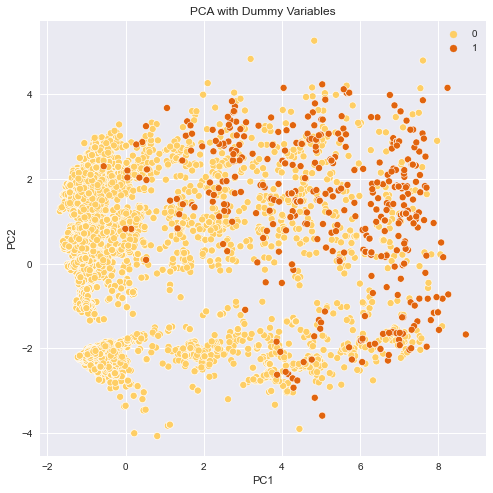

In [430]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_final, x='PC1',y='PC2',hue=df_final.is_fraud.tolist(),palette='YlOrBr')
plt.title('PCA with Dummy Variables');

In [431]:
df_final.query('PC1 < 0')['is_fraud'].sum()

2

In [432]:
print("The number of points with PC1 below 0 is",len(df_final.query('PC1 < 0')),"with", df_final.query('PC1 < 0')['is_fraud'].sum(), "being fraud")

The number of points with PC1 below 0 is 8105 with 2 being fraud


There is certainly a useable pattern in the PCA viz above. I can see that there is a single fraud transaction below 0 on PC1, and much fewer below 2 than above, and a lower amount of fraud on PC2 below 0. 

If I classified everything with PC1 score below 0 as not fraud, I would have one false negative out of the hundreds there. **It would also go a long way to balancing the classes from what was left over.**

After running my first Random Forest below, I'll add the PCs into my model as an experiment to see if this has any impact on my model performance.

If that doesn't yield the desired result, I will simply exclude PC1 scores below 0 from the data, and train my model on just those with PC1 scores above, then combine the results.

In [433]:
# x matrix with PC scores added to use later on
X_with_pc = pd.concat([X,df_pca], axis=1)

### Random Forest 

In [434]:
forest = RandomForestClassifier(n_estimators=5000)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

#getting probabilities for 0-1 predictions
probs_forest = forest.predict_proba(X_test)[:, 1]

#confusion matrix
cm = confusion_matrix(y_test,y_pred)
forest_cm = pd.DataFrame(cm)
print(forest_cm.rename(index={0:'Not Fraud', 1:'Fraud'}, columns={0:'Predicted Not Fraud', 1:'Predicted Fraud'}))

#classification report
print('\n',classification_report(y_test, y_pred, digits=4))

#getting decision types
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_pred).ravel()

print('False Negative Rate after Random Forest: ',round(false_neg/true_neg * 100,2), '%', sep='')
print('False Positive Rate after Random Forest: ',round(false_pos/true_neg * 100,2), '%', sep='')

eli5.show_weights(forest,feature_names=list(X.columns))

           Predicted Not Fraud  Predicted Fraud
Not Fraud                 2440                9
Fraud                       43               78

               precision    recall  f1-score   support

           0     0.9827    0.9963    0.9895      2449
           1     0.8966    0.6446    0.7500       121

    accuracy                         0.9798      2570
   macro avg     0.9396    0.8205    0.8697      2570
weighted avg     0.9786    0.9798    0.9782      2570

False Negative Rate after Random Forest: 1.76%
False Positive Rate after Random Forest: 0.37%


Weight,Feature
0.1913 ± 0.2500,transaction_count
0.0822 ± 0.0905,lev_distance
0.0792 ± 0.1794,ip_fraud_pct
0.0658 ± 0.0718,customer_id
0.0639 ± 0.1286,has_paid_before
0.0537 ± 0.1370,domain_hotmailcom
0.0518 ± 0.0406,purchase_amount
0.0506 ± 0.0428,purchase_hour
0.0452 ± 0.1380,ip_country_SE
0.0423 ± 0.0302,purchase_div_salary


### Random Forest with PC scores added as features

In [435]:
#creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_with_pc, y, test_size = 0.25,
                                                    random_state = 0)

forest = RandomForestClassifier(n_estimators=5000)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

probs_forest = forest.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,y_pred)
forest_cm = pd.DataFrame(cm)
print(forest_cm.rename(index={0:'Not Fraud', 1:'Fraud'}, columns={0:'Predicted Not Fraud', 1:'Predicted Fraud'}))

print(classification_report(y_test, y_pred, digits=4))


true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_pred).ravel()


print('False Negative Rate after Random Forest: ',round(false_neg/true_neg * 100,2), '%', sep='')
print('False Positive Rate after Random Forest: ',round(false_pos/true_neg * 100,2), '%', sep='')


eli5.show_weights(forest,feature_names=list(X_with_pc.columns))

           Predicted Not Fraud  Predicted Fraud
Not Fraud                 2439               10
Fraud                       42               79
              precision    recall  f1-score   support

           0     0.9831    0.9959    0.9895      2449
           1     0.8876    0.6529    0.7524       121

    accuracy                         0.9798      2570
   macro avg     0.9354    0.8244    0.8709      2570
weighted avg     0.9786    0.9798    0.9783      2570

False Negative Rate after Random Forest: 1.72%
False Positive Rate after Random Forest: 0.41%


Weight,Feature
0.1706 ± 0.2508,transaction_count
0.1362 ± 0.2359,PC1
0.0676 ± 0.0753,PC2
0.0641 ± 0.0907,lev_distance
0.0615 ± 0.1698,ip_fraud_pct
0.0528 ± 0.0662,customer_id
0.0483 ± 0.1267,has_paid_before
0.0409 ± 0.0361,purchase_amount
0.0394 ± 0.1321,domain_hotmailcom
0.0385 ± 0.0372,purchase_hour


### Conclusion - Random Forest with PCA as features

In spite of seeing a clear pattern in the PCA scatter plot, and PC1 being attributed as a high value feature in the eli5 analysis, there was a slight degradation in the performance on the false positive rate, and no change to the false negative rate

### Random Forest with PC1 scores below zero removed from data

In [436]:
df_pc1_abv_0 = pd.concat([X_with_pc, y],axis=1)
df_pc1_abv_0 = df_pc1_abv_0.query('PC1 > 0')

X_pc1_abv_0 = df_pc1_abv_0.iloc[:,:-1]

y_pc1_abv_0 = df_pc1_abv_0.iloc[:,-1]

#creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pc1_abv_0, y_pc1_abv_0, test_size = 0.25,
                                                    random_state = 0)

forest = RandomForestClassifier(n_estimators=5000)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

probs_forest = forest.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,y_pred)
forest_cm = pd.DataFrame(cm)
forest_cm.rename(index={0:'Not Fraud', 1:'Fraud'}, columns={0:'Predicted Not Fraud', 1:'Predicted Fraud'},inplace=True)
print(forest_cm)

print(classification_report(y_test, y_pred, digits=4))

true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_pred).ravel()

#for adding the datapoints back in, preassigned as not fraudulent
pre_assigned_notfraud = X_with_pc.query('PC1 < 0').shape[0] * .25


print('False Negative Rate after Random Forest: ',round((false_neg + .25)/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')
print('False Positive Rate after Random Forest: ',round(false_pos/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')

eli5.show_weights(forest,feature_names=list(X_pc1_abv_0.columns))

           Predicted Not Fraud  Predicted Fraud
Not Fraud                  421                6
Fraud                       38               78
              precision    recall  f1-score   support

           0     0.9172    0.9859    0.9503       427
           1     0.9286    0.6724    0.7800       116

    accuracy                         0.9190       543
   macro avg     0.9229    0.8292    0.8652       543
weighted avg     0.9196    0.9190    0.9139       543

False Negative Rate after Random Forest: 1.56%
False Positive Rate after Random Forest: 0.25%


Weight,Feature
0.1794 ± 0.2415,transaction_count
0.1111 ± 0.1500,PC1
0.0953 ± 0.1459,lev_distance
0.0750 ± 0.0868,PC2
0.0635 ± 0.0729,purchase_hour
0.0572 ± 0.0624,customer_id
0.0467 ± 0.0406,purchase_amount
0.0418 ± 0.0887,ip_fraud_pct
0.0397 ± 0.0309,purchase_div_salary
0.0393 ± 0.0313,annual_salary


### Random Forest with rows with PC1 scores below zero removed from data, and PCA scores excluded from model altogether

In [437]:
df_pc1_abv_0 = pd.concat([X_with_pc, y],axis=1)
df_pc1_abv_0 = df_pc1_abv_0.query('PC1 > 0')

X_pc1_abv_0 = df_pc1_abv_0.iloc[:,:-3]
y_pc1_abv_0 = df_pc1_abv_0.iloc[:,-1]

#creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pc1_abv_0, y_pc1_abv_0, test_size = 0.25,
                                                    random_state = 0)

forest = RandomForestClassifier(n_estimators=5000)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

probs_forest = forest.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,y_pred)
forest_cm = pd.DataFrame(cm)
forest_cm.rename(index={0:'Not Fraud', 1:'Fraud'}, columns={0:'Predicted Not Fraud', 1:'Predicted Fraud'})

print(forest_cm)

print(classification_report(y_test, y_pred, digits=4))


true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_pred).ravel()

print('Fraud Rate after Random Forest: ',round((false_neg + .25)/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')
print('False Positive Rate after Random Forest: ',round(false_pos/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')


eli5.show_weights(forest,feature_names=list(X_pc1_abv_0.columns))

     0   1
0  421   6
1   41  75
              precision    recall  f1-score   support

           0     0.9113    0.9859    0.9471       427
           1     0.9259    0.6466    0.7614       116

    accuracy                         0.9134       543
   macro avg     0.9186    0.8163    0.8543       543
weighted avg     0.9144    0.9134    0.9075       543

Fraud Rate after Random Forest: 1.69%
False Positive Rate after Random Forest: 0.25%


Weight,Feature
0.2031 ± 0.2403,transaction_count
0.1185 ± 0.1388,lev_distance
0.0767 ± 0.0757,purchase_hour
0.0707 ± 0.0686,customer_id
0.0572 ± 0.0437,purchase_amount
0.0494 ± 0.0872,ip_fraud_pct
0.0494 ± 0.0348,purchase_div_salary
0.0481 ± 0.0340,annual_salary
0.0457 ± 0.0866,has_paid_before
0.0434 ± 0.0306,age


# Random Forest with PC1 < 0 removed, PC2 left as feature

In [438]:
df_pc1_abv_0 = pd.concat([X_with_pc, y],axis=1)
df_pc1_abv_0 = df_pc1_abv_0.query('PC1 > 0')

X_pc1_abv_0 = df_pc1_abv_0.drop(columns=['PC1','is_fraud'])

y_pc1_abv_0 = df_pc1_abv_0.iloc[:,-1]

#creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pc1_abv_0, y_pc1_abv_0, test_size = 0.25,
                                                    random_state = 0)

forest = RandomForestClassifier(n_estimators=5000)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

probs_forest = forest.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,y_pred)
forest_cm = pd.DataFrame(cm)
forest_cm.rename(index={0:'Not Fraud', 1:'Fraud'}, columns={0:'Predicted Not Fraud', 1:'Predicted Fraud'})
print(forest_cm)

print(classification_report(y_test, y_pred, digits=4))

true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_pred).ravel()

print('False Negative Rate after Random Forest: ',round((false_neg + .25)/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')
print('False Positive Rate after Random Forest: ',round(false_pos/(true_neg + pre_assigned_notfraud) * 100,2), '%', sep='')


eli5.show_weights(forest,feature_names=list(X_pc1_abv_0.columns))

     0   1
0  419   8
1   39  77
              precision    recall  f1-score   support

           0     0.9148    0.9813    0.9469       427
           1     0.9059    0.6638    0.7662       116

    accuracy                         0.9134       543
   macro avg     0.9104    0.8225    0.8565       543
weighted avg     0.9129    0.9134    0.9083       543

False Negative Rate after Random Forest: 1.61%
False Positive Rate after Random Forest: 0.33%


Weight,Feature
0.1958 ± 0.2428,transaction_count
0.1060 ± 0.1457,lev_distance
0.0811 ± 0.0911,PC2
0.0713 ± 0.0753,purchase_hour
0.0639 ± 0.0655,customer_id
0.0527 ± 0.0424,purchase_amount
0.0509 ± 0.0906,ip_fraud_pct
0.0445 ± 0.0330,purchase_div_salary
0.0436 ± 0.0326,annual_salary
0.0397 ± 0.0823,has_paid_before


## Random Forest Results - experiementing with PCA values

- Model: Random Forest
 - False Neg: **1.72%**
 - False Positive: **0.37%**

- Model: Random Forest w/ PC1 and PC2 as features
 - False Neg: **1.68%**
 - False Positive: **0.41%**

- Model: Random Forest w/ PC1 and PC2 as features, PC1 < 0 records removed
 - False Neg: **1.56%**
 - False Positive: **0.33%**

- Model: Random Forest w/ PC1 < 0 records removed, No PCA features
 - False Neg: **1.69%**
 - False Positive: **0.33%**
 
- Model: Random Forest w/ PC1 < 0 records removed, PC2 as feature
 - False Neg: **1.56%**
 - False Positive: **0.37%**
 
Of the different versions of the Random Forest model tested, based on False Negative and False positive rates, the favourite is:
**Random Forest w/ PC1 and PC2 as features, PC1 < 0 records removed**

This model yielded the lowest False Negative rate (caught the most fraud) and yielded the tied-lowest False Positive rate - which is arguably the most important metric when changes to the False Negative rate are negligible